# Detector Correction

In this first notebook, the effects of correcting for the artefacts in images caused by the detector system are explored. The relevant detector system consists of a microchannel plate (MCP) for electron amplification, a fluorescent screen to convert to photons and a CCD camera. Calibration of the gain vs MCP bias voltage, and subtraction of the dark current, followed by [flat fielding](https://en.wikipedia.org/wiki/Flat-field_correction), compensates artefacts and allows for conversion to true reflectivity spectra.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyL5.lib.analysis.container import Container
from scipy.optimize import least_squares

In [2]:
# We always grab a part of the center of the image for calibration
radius = 100
folder = './data/'
DCcont = Container(folder+'20171205_115846_0.66um_475.8_DC.nlp')

DC = DCcont.getStack().getDaskArray().mean(axis=0)

DCval = DC[(640-radius):(640+radius), (512-radius):(512+radius)].mean()

./data/20171205_115846_0.66um_475.8_DC.nlp


## Calibration of $G(V_{MCP})$

We calibrate the gain of the MCP, by fitting Image intensity versus gain $G(V_{MCP})$. First we load the reference data:

In [3]:
conts = []
CPvals = []
Ivals = []
Iorigs = []
EGY = []

for file in ['20171205_143305_31um_474.2_sweepCHANNELPLATE_SET_higherintensity', 
             '20171205_103440_0.66um_479.2_sweepCHANNELPLATE_SET_highintensity', 
             '20171205_100540_0.66um_479.2_sweepCHANNELPLATE_SET_lowintensity_v2', 
             ]:
    cont = Container(folder+file+'.nlp')
    conts.append(cont)
    CP = np.array(cont['CHANNELPLATE'])
    Orig = cont.getStack().getDaskArray()
    DCcor = Orig - DC
    Orig = Orig[:, (640-radius):(640+radius), (512-radius):(512+radius)].mean(axis=(1,2))
    DCcor = DCcor[:, (640-radius):(640+radius), (512-radius):(512+radius)].mean(axis=(1,2))
    Iorigs.append(Orig)
    CPvals.append(CP)
    Ivals.append(DCcor)
    EGY.append(cont["EGY"][0])
Ivals = np.stack(Ivals)
CPvals = np.stack(CPvals)
Iorigs = np.stack(Iorigs)

./data/20171205_143305_31um_474.2_sweepCHANNELPLATE_SET_higherintensity.nlp
./data/20171205_103440_0.66um_479.2_sweepCHANNELPLATE_SET_highintensity.nlp
./data/20171205_100540_0.66um_479.2_sweepCHANNELPLATE_SET_lowintensity_v2.nlp


As described in the paper, we fit a function of the following form:

$G(V_\text{MCP}) = A_i\exp\left(\sum_{k=0}^5 c_k {V_\text{MCP}}^{2k+1}\right)$

In [4]:
# Fitting and error function definitions

def odd_polynomial(x, *coeffs):
    res = np.zeros_like(x)
    for index in range(len(coeffs)):
        res += coeffs[index]*np.power(x, 2*index + 1)
    return res

def polynomial(x, *coeffs):
    res = np.zeros_like(x)
    for index in range(len(coeffs)):
        res += coeffs[index]*np.power(x, index + 1)
    return res

def mod_exp(x, *coeffs):
    return np.exp(-1*odd_polynomial(x, *coeffs))

def fit_func(CP, *params):
    """The joint fit function."""
    Amps = np.array(params[:CP.shape[0]])[:,np.newaxis]
    return Amps * mod_exp(CP, *params[CP.shape[0]:])

def err_func(params, CP, I):
    """Logarithmic error function"""
    return (np.log(fit_func(CP, *params)) - np.log(I)).ravel()

In [5]:
fullres = least_squares(err_func, [1,1,1,1, 0,0,0,0, 0,0,0,0], args=(CPvals, Ivals), 
                         max_nfev=1000000)
res = fullres['x']
fullres['message']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


'`ftol` termination condition is satisfied.'

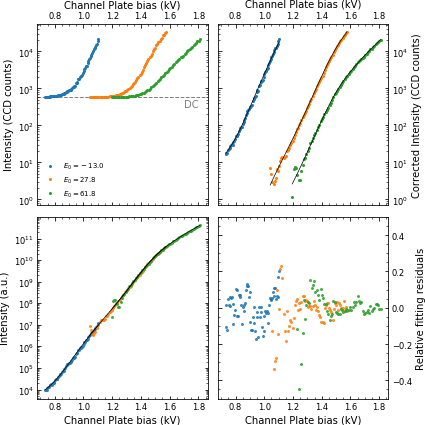

In [6]:
fix, axs = plt.subplots(ncols=2, nrows=2, figsize=[6,6], sharex=True, constrained_layout=True)
axs = axs.flatten()
axs[0].axhline(DCval, color='black', alpha=0.5, linestyle='--')
axs[0].annotate('DC', xy=(1.7, DCval/1.8), color='black', alpha=0.5)
for i in range(len(EGY)):
    axs[0].semilogy(CPvals[i], Iorigs[i], '.', markersize=4, label=r"$E_0={:.1f}$".format(EGY[i]))
axs[0].legend()

axs[1].semilogy(CPvals.T, Ivals.T, '.', markersize=4)
axs[1].semilogy(CPvals.T, fit_func(CPvals, *res).T, 
                  color='black', linewidth=0.7, label='fit')
axs[2].semilogy(CPvals.T, Ivals.T/res[:3], '.', markersize=4, alpha=0.8)
axs[2].semilogy(CPvals.T, fit_func(CPvals, *res).T/res[:3], 
              color='black', linewidth=0.7, label='fit')
axs[3].plot(CPvals.T, 
            ((Ivals - fit_func(CPvals, *res)).T/res[:3]) / (fit_func(CPvals, *res).T/res[:3]), 
            '.', alpha=0.8, markersize=4)
axs[3].set_ylim([-0.5,0.5])
for ax in axs:
    ax.set_xlabel('Channel Plate bias (kV)')
axs[0].set_ylim(axs[1].get_ylim())
axs[0].set_ylabel('Intensity (CCD counts)')
axs[1].set_ylabel('Corrected Intensity (CCD counts)')
axs[2].set_ylabel('Intensity (a.u.)')
axs[3].set_ylabel('Relative fitting residuals')
for ax in [axs[1], axs[3]]:
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', labelright=True, labelleft=False)
for ax in axs[:2]:
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.savefig(f'Channelplate_calibration_test_{len(res)}.pdf')

## Flatfielding 

In [7]:
cont = Container(folder + '20171120_160356_3.5um_591.4_IVhdr.nlp')
data = cont.getStack().getDaskArray()
multiplier = np.array(cont["MULTIPLIER"])

./data/20171120_160356_3.5um_591.4_IVhdr.nlp


In [8]:
# Use the mirror mode, where all electrons are reflected, as flat field
FF = data[:32].mean(axis=0)
rawimage = data[77]
CPcorimage = ((rawimage-DC) / (FF-DC)) / (multiplier[77] / multiplier[:32].mean())

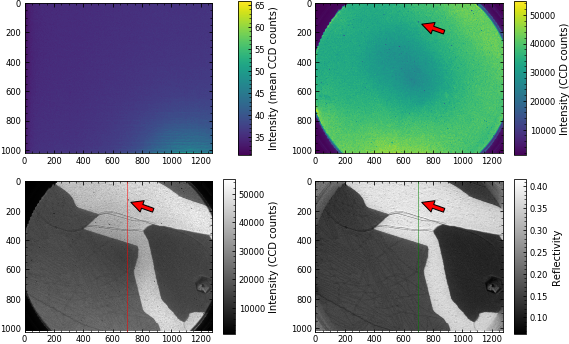

In [9]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=[8, 4.9])
im = axs[0,0].imshow(DC.T/16., interpolation='none')
fig.colorbar(im, ax=axs[0,0], label='Intensity (mean CCD counts)', pad=0)
im = axs[0,1].imshow(FF.T, interpolation='none')
fig.colorbar(im, ax=axs[0,1], label='Intensity (CCD counts)')
im = axs[1,0].imshow(rawimage.T, cmap='gray', interpolation='none')
fig.colorbar(im, ax=axs[1,0], label='Intensity (CCD counts)')
im2 = axs[1,1].imshow(CPcorimage.T, cmap='gray', interpolation='none')
fig.colorbar(im2, ax=axs[1,1], label='Reflectivity')
axs[1,0].axvline(700, color='red', alpha=0.5)
axs[1,1].axvline(700, color='green', alpha=0.5)
for ax in axs.flatten()[1:]:
    ax.annotate('', xy=(705, 1024-887),  xycoords='data',
            xytext=(0.7, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.1),
            horizontalalignment='right', verticalalignment='top',
            )
plt.savefig('DC_and_Flatfield.pdf', dpi=300)

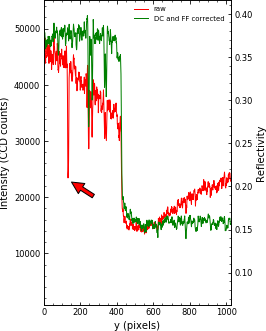

In [10]:
fig, ax = plt.subplots(figsize=[4,4.9])
ln1 = plt.plot(rawimage[700,:], label='raw', color='red')
plt.ylabel('Intensity (CCD counts)')
plt.xlabel('y (pixels)')
plt.ylim(im.get_clim())
plt.twinx()
ln2 = plt.plot(CPcorimage[700,:], label='DC and FF corrected', color='green')
plt.ylabel('Reflectivity')
plt.ylim(im2.get_clim())
ax.annotate('', xy=(1024-887, 23000),  xycoords='data',
            xytext=(0.28, 0.35), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.1),
            horizontalalignment='right', verticalalignment='top',
            )
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
plt.margins(x=0, y=0, tight=True)
plt.legend(lns, labs)
plt.tight_layout()
plt.savefig('DC_and_Flatfield2.pdf', dpi=300)

## Comparison of results
Finally, we visualize the effect of active tuning of the gain by plotting a spectrum measured with regular settings and one with adaptive gain.

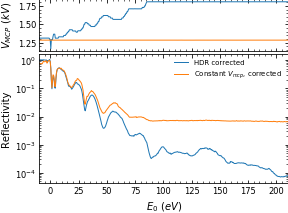

In [11]:
Ehdr, Ihdr = np.genfromtxt(folder+'20190509_142203_3.5um_561.5_IVhdrBILAYER.csv', unpack=True)
E, I = np.genfromtxt(folder+'20190509_155656_3.5um_562.1_IVBILAYER.csv', unpack=True)
CP = np.genfromtxt(folder+'20190509_155656_3.5um_562.1_IV_CHANNELPLATE.txt')
CPhdr = np.genfromtxt(folder+'20190509_142203_3.5um_561.5_IVhdr_CHANNELPLATE.txt')
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [0.8,2]}, sharex=True, figsize=[4,3])
axs[0].plot(Ehdr, CPhdr)
axs[0].plot(E, CP)
axs[0].margins(x=0)
axs[0].set_ylabel('$V_{MCP}\ (kV)$')
axs[1].semilogy(Ehdr,Ihdr, label='HDR corrected')
axs[1].semilogy(E,I, label='Constant $V_{mcp}$, corrected')
axs[1].margins(x=0)
axs[1].set_xlabel('$E_0\ (eV)$')
axs[1].set_ylabel('Reflectivity')
axs[1].legend()
plt.tight_layout(h_pad=0.0, pad=0)
plt.savefig('HDRcomparison.pdf')